In [1]:
#Shishir Khanal
#Feedforward Control in Julia
#https://dewdotninja.github.io/julia/control/julia_control.html
using Pkg;
Pkg.add("ControlSystems");
Pkg.add("Plots");
using ControlSystems, Plots;

    Updating registry at `C:\Users\Khanalshis\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`


In [2]:
#Feedforward Control can accompany Feedback control to improve tracking
#T(s) = (P(s)C(s) + P(s)F(s)) / (1 + P(s)C(s))
#Problem: Assume J = 8, B = 0.01 and that these params can be estimated within ±p% accuracy.
#         Compare tracking when feedforward control is turned on and off

In [12]:
#3-segment trajectory as desired path for joint
function cpoly(q0, qf, t, qd0=0, qdf=0)
    tf = t[end]
    T = [0 0 0 1;tf^3 tf^2 tf 1; 0 0 1 0; 3tf^2 2tf 1 0]
    b = [q0 qf qd0 qdf]'
    coeffs = inv(T)*b
    coeffs_d = coeffs[1:3].*reverse(collect(1:3))
    coeffs_dd = coeffs_d[1:2].*reverse(collect(1:2))
    
    q = polyval(coeffs, t)
    q_d = polyval(coeffs_d,t)
    q_dd = polyval(coeffs_dd,t)
    return q, q_d, q_dd
end

cpoly (generic function with 3 methods)

In [15]:
function polyval(P, X)
    Y = zeros(size(X))
    n = size(P,1)
    for i=1:n
        Y = Y + P[i]*X.^(n-i)
    end
    return Y
end

polyval (generic function with 1 method)

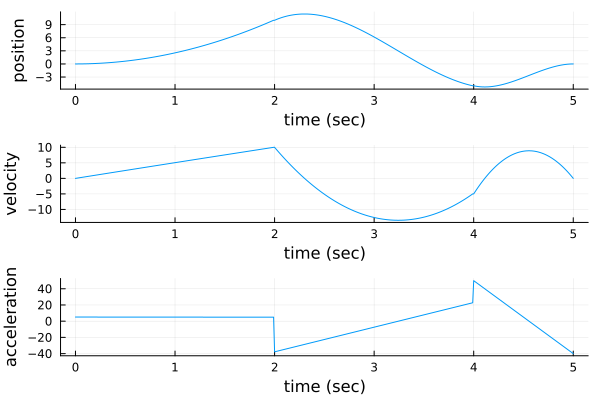

In [22]:
begin
    t1 = collect(0:0.01:1.99)
    t2 = collect(0:0.01:1)
    q1,qd1,qdd1 = cpoly(0,10,t1,0,10)
    q2,qd2,qdd2 = cpoly(10,-5,t1,10,-5)
    q3,qd3,qdd3 = cpoly(-5,0,t2,-5,0)
    q = [q1; q2; q3]
    qd = [qd1; qd2; qd3]
    qdd = [qdd1; qdd2; qdd3]
    tvec = [t1; 2 .+ t1; 4 .+ t2]
    plot_q = plot(tvec, q, ylabel="position")
    plot_qd = plot(tvec, qd, ylabel="velocity")
    plot_qdd = plot(tvec, qdd, ylabel="acceleration")
    plotall = plot(plot_q, plot_qd, plot_qdd, layout=(3,1), legend=false)
    xlabel!("time (sec)")
end

In [23]:
begin
    J = 8
    B = 0.01
    s = tf("s")
    P = 1/(J*s^2 +B*s)
    C = 4000*(s+0.1)/(s+30)
end

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
4000.0s + 400.0
---------------
  1.0s + 30.0

Continuous-time transfer function model

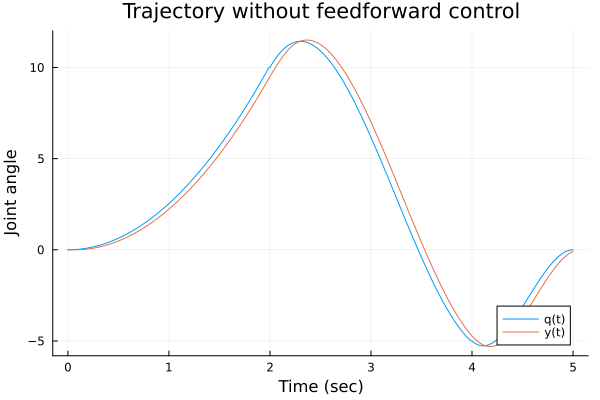

In [30]:
begin
    L = C*P
    T = feedback(L)
    q_1 = reshape(q,(1,size(q)...))
    y,t,x = lsim(T, q_1, tvec, method=:zoh)
    y = dropdims(y,dims=1)
    q_1 = dropdims(q_1,dims=1)
    plot(t, q_1, label="q(t)")
    plot!(t,y,label="y(t)", xlabel="Time (sec)", ylabel="Joint angle",
    title="Trajectory without feedforward control", legend=:bottomright)
end

In [32]:
#Now traking performance with Feedforward Controller
begin
    p = 10 # p∈[0,100]
    Jm = (1 + (p/100)*rand())*J
    Bm = (1 + (p/100)*rand())*B
end

0.010517138152528019

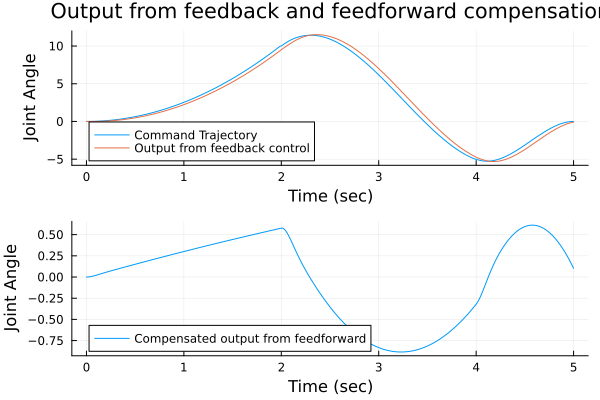

In [35]:
begin
    u_ff = Jm * qdd + Bm * qd
    S = 1 / (1 + L)
    PS = P*S
    sys = append(T, PS)
    u = [q u_ff]'
    yₐ, tₐ, xₐ = lsim(sys, u, tvec, method=:zoh)
    p1 = plot(tₐ, q, label="Command Trajectory")
    #size(yₐ)
    plot!(tₐ, yₐ[1,:], label="Output from feedback control", xlabel="Time (sec)", ylabel="Joint Angle",
    title="Output from feedback and feedforward compensation", legend=:bottomleft)
    p2 = plot(tₐ,yₐ[2,:], label="Compensated output from feedforward", xlabel="Time (sec)", ylabel="Joint Angle", legend=:bottomleft)
    plot(p1,p2,layout=(2,1))    
end

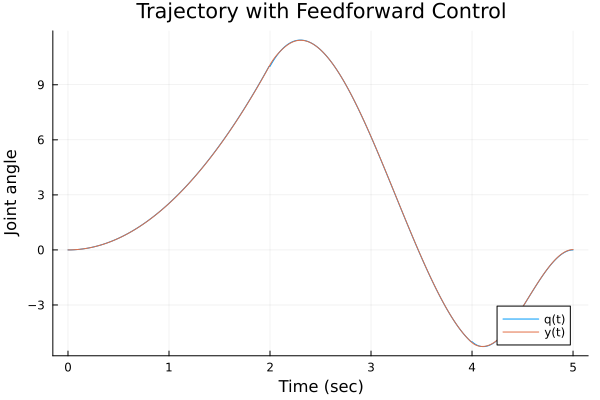

In [36]:
begin
    y₂ = yₐ[1,:]+yₐ[2,:]
    plot(t,q, label="q(t)")
    plot!(t, y₂, label="y(t)", xlabel="Time (sec)", ylabel = "Joint angle",
    title="Trajectory with Feedforward Control", legend=:bottomright)
end